In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
from itertools import islice
import pickle
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import k_clique_communities
import matplotlib.pyplot as plt 
import scipy.sparse as sp
import random
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn import metrics,model_selection,preprocessing
import warnings
warnings.filterwarnings("ignore")
random.seed(32)
np.random.seed(32)


/home/wumx/anaconda3/envs/OpenNE/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# 读取文件中的正负边
def read_edges(filename):
    pos_edges = set()
    neg_edges = set()
    with open(filename, 'r') as f:
        for line in f:
            words = line.split()
            node1 = words[0]
            node2 = words[1]
            label = words[2]
            if label == '1':
                pos_edges.add((node1, node2))
            else:
                neg_edges.add((node1, node2))
#     print("{}\n{}".format(len(nodeList1),len(nodeList2)))
    return list(pos_edges), list(neg_edges)

def read_embeddings(embedding_file):
    embeddings={}
    with open(embedding_file, 'r') as f:
        first_line=f.readline()
        node_nums,dimension=first_line.split()
        print("{} {}".format(node_nums,dimension))
        for line in f:
            line=line.split()
            embeddings[line[0]]=line[1:]
    return embeddings,int(dimension)

def get_embedding_features(embedding_file,pos_edges,neg_edges):
    embeddings,embedding_dimension=read_embeddings(embedding_file)
    #边的特征
    #提取正例特征
    pos_embedding_features=[]
    label=[]
    for edge in pos_edges:
        if edge[0][0]=='C' and len(edge[0])==8:
            disease_id,gene_id=edge
        else:
            gene_id,disease_id=edge
        #print(edge)
        pos_embedding_features.append(np.hstack((embeddings[disease_id],embeddings[gene_id])))
        label.append(1)

    #提取负例特征
    neg_embedding_features=[]
    for edge in neg_edges:
        if edge[0][0]=='C' and len(edge[0])==8:
            disease_id,gene_id=edge
        else:
            gene_id,disease_id=edge
        #print(edge)
        neg_embedding_features.append(np.hstack((embeddings[disease_id],embeddings[gene_id])))
        label.append(0)
    train_embedding_features=np.vstack((pos_embedding_features,neg_embedding_features))
    return train_embedding_features

#加载网络
def loadNet(fileName):
    edges=set()
    with open(fileName, 'r') as f:
        for line in f:
            words = line.split()
            edges.add((words[0], words[1]))
    return edges


def all_metric(model,X_test,y_test):
    y_prob = model.predict_proba(X_test)
    f1=metrics.f1_score(y_test,model.predict(X_test))
    print("f1:{}".format(f1))
    y_test_prob=model.predict_proba(X_test)   #y_test_prob.shape=[n_samples, n_classes]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob[:,1])
    auc=metrics.auc(fpr,tpr)
    print("auc:{}".format(auc))
    plt.title('ROC Validation')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return 
    
def run(model,train_data_file,feature_columns,test_size):
    train_data=pd.read_csv(train_data_file)
    train_data = shuffle(train_data)
    X = train_data[feature_columns]
    Y = train_data['label']
#     X = preprocessing.scale(X)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=7)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    predictions = [round(value) for value in y_pred]
    # evaluate predictions
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    all_metric(model,X_test,y_test)
    
def extract_struct_feature(G,trainEdgeFile,savePath):
    degree = dict(G.degree())  # 返回所有节点的度
    # degree_connect=dict(degree_connect)
    centrality=nx.degree_centrality(G)
    cluster_coefficient=nx.clustering(G)
    pos_edges,neg_edges=read_edges(trainEdgeFile)
    
    pos_ra=list(nx.resource_allocation_index(G,pos_edges))
    pos_jc=list(nx.jaccard_coefficient(G,pos_edges))
    pos_aa=list(nx.adamic_adar_index(G,pos_edges))
    pos_pa=list(nx.preferential_attachment(G,pos_edges))
    # pos_cn=list(nx.common_neighbor_centrality (G,pos_edges)) #运行时间长
    # pos_rash=list(nx.ra_index_soundarajan_hopcroft(G,pos_edges))   需要社区信息
    # pos_wic=list(nx.within_inter_cluster(G,pos_edges)) 需要社区信息
    pos_ra_val=[val for node1,node2,val in pos_ra]
    pos_jc_val=[val for node1,node2,val in pos_jc]
    pos_pa_val=[val for node1,node2,val in pos_pa]
    pos_edge_feature=np.array([pos_ra_val,pos_jc_val,pos_pa_val]).T
    
    neg_ra=list(nx.resource_allocation_index(G,neg_edges))
    neg_jc=list(nx.jaccard_coefficient(G,neg_edges))
    neg_pa=list(nx.preferential_attachment(G,neg_edges))
    neg_ra_val=[val for node1,node2,val in neg_ra]
    neg_jc_val=[val for node1,node2,val in neg_jc]
    neg_pa_val=[val for node1,node2,val in neg_pa]
    neg_edge_feature=np.array([neg_ra_val,neg_jc_val,neg_pa_val]).T
    
    #节点特征提取
    # 提取正例特征
    pos_node_features = []
    label = []
    for edge in pos_edges:
        feature=[]
        if edge[0][0] == 'C' and len(edge[0]) == 8:
            disease_id, gene_id = edge
        else:
            gene_id, disease_id = edge
        pos_node_features.append((degree[disease_id], degree[gene_id],centrality[disease_id], centrality[gene_id],cluster_coefficient[disease_id], cluster_coefficient[gene_id]))
        label.append(1)
     # 提取负例特征
    neg_node_features = []
    for edge in neg_edges:
        if edge[0][0] == 'C' and len(edge[0]) == 8:
            disease_id, gene_id = edge
        else:
            gene_id, disease_id = edge
        neg_node_features.append((degree[disease_id], degree[gene_id],centrality[disease_id], centrality[gene_id],cluster_coefficient[disease_id], cluster_coefficient[gene_id]))
        label.append(0)
        
    pos_node_features=np.array(pos_node_features)
    pos_struct_features=np.hstack((pos_node_features,pos_edge_feature))
    neg_node_features=np.array(neg_node_features)
    neg_struct_features=np.hstack((neg_node_features,neg_edge_feature))
    struct_features = np.vstack((pos_struct_features,neg_struct_features))
    # 基于边的特征
    feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
    struct_train_data = pd.DataFrame(struct_features, columns=feature_columns)
    struct_train_data['label'] = label
    struct_train_data.to_csv(savePath, index=False)
    return struct_train_data

In [3]:
#批量提取网络表征特征
negRatio = [0.5,1,1.5,2,2.5,3,3.5,4,4.5]
posEdgeFile="network_edgelist/connectiveSample_edges0.1.txt"
filePredix="network_edgelist/connectiveSample_negPosRatio"
for sampleRatio in negRatio:
    network=nx.read_adjlist("network_edgelist/allNetworkConnective0.1.txt")
    trainEdgeFile=filePredix+str(sampleRatio)+".txt"
    savePath="train_data/struct_connective_negPosRatio"+str(sampleRatio)+".csv"
    struct_train_data=extract_struct_feature(network,trainEdgeFile,savePath)

In [3]:
#批量提取网络表征特征
posSampleRatio = [x/10 for x in range(1, 10)]
filePredix = "network_edgelist/connectiveSample_edges"
for sampleRatio in posSampleRatio:
    network=nx.read_adjlist("network_edgelist/allNetworkConnective"+str(sampleRatio)+".txt")
    trainEdgeFile="network_edgelist/connectiveSample_edges" + str(sampleRatio)+".txt"
    savePath="train_data/struct_connective_traindata"+str(sampleRatio)+".csv"
    struct_train_data=extract_struct_feature(network,trainEdgeFile,savePath)

In [170]:
G_connect=nx.read_adjlist("network_edgelist/all_network_adjlist_connective.txt")
trainEdgeFile="network_edgelist/connectiveSample_edges0.5.txt"
savePath="train_data/struct_connective_traindata.csv"
struct_train_data=extract_struct_feature(G_connect,trainEdgeFile,savePath)

struct_connective_traindata
Accuracy: 84.38%
f1:0.8453943635331945
auc:0.9272547815673837


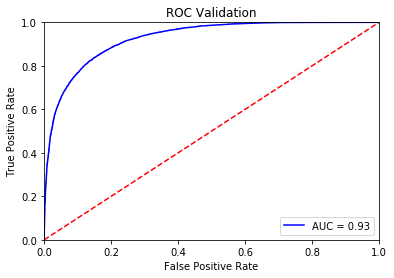

In [171]:
#未归一化
print("struct_connective_traindata")
test_size = 0.2
model =XGBClassifier()#SVC()# LogisticRegression()
feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
train_data_file="train_data/struct_connective_traindata.csv"
run(model,train_data_file,feature_columns,test_size)

In [ ]:
G_random=nx.read_adjlist("network_edgelist/all_network_adjlist_random.txt")
trainEdgeFile="network_edgelist/connectiveSample_edges0.5.txt"
savePath="train_data/struct_connective_traindata.csv"
struct_train_data=extract_struct_feature(G_connect,trainEdgeFile,savePath)

In [146]:
data_path='original_data/'
dis_gene_file = data_path+'DisGeNet_dis_gene.txt' #疾病基因网络
dis_symp_file = data_path+'HPO&Orphanet_dis_symp.txt' #疾病表型网络
gene_go_file = data_path+'homo_gene_GO.txt' #基因本体网络
ppi_file = data_path+'blab_ppi2016.txt' #ppi网络

dis_gene_edges=loadNet(dis_gene_file)
dis_symp_edges=loadNet(dis_symp_file)
gene_go_edges=loadNet(gene_go_file)
ppi_edges=loadNet(ppi_file)

In [147]:
G=nx.Graph()
G.add_edges_from(dis_gene_edges)
G.add_edges_from(dis_symp_edges)
G.add_edges_from(gene_go_edges)
G.add_edges_from(ppi_edges)

In [148]:
# c = list(greedy_modularity_communities(G)) #社区发现
#一下返回的均为map格式
degree = G.degree()  # 返回所有节点的度
degree=dict(degree)
centrality=nx.degree_centrality(G)
cluster_coefficient=nx.clustering(G)
# transitivity=nx.transitivity(G) #值
# closeness_centrality=nx.closeness_centrality(G) #运行时间长
# betweenness_centrality=nx.betweenness_centrality(G) #运行时间长

In [149]:
connectiveSample_edges="network_edgelist/connectiveSample_edges0.5.txt"
pos_edges,neg_edges=read_edges("network_edgelist/connectiveSample_edges0.5.txt")

In [150]:
pos_ra=list(nx.resource_allocation_index(G,pos_edges))
pos_jc=list(nx.jaccard_coefficient(G,pos_edges))
pos_aa=list(nx.adamic_adar_index(G,pos_edges))
pos_pa=list(nx.preferential_attachment(G,pos_edges))
# pos_cn=list(nx.common_neighbor_centrality (G,pos_edges)) #运行时间长
# pos_rash=list(nx.ra_index_soundarajan_hopcroft(G,pos_edges))   需要社区信息
# pos_wic=list(nx.within_inter_cluster(G,pos_edges)) 需要社区信息

pos_ra_val=[val for node1,node2,val in pos_ra]
pos_jc_val=[val for node1,node2,val in pos_jc]
pos_pa_val=[val for node1,node2,val in pos_pa]
pos_edge_feature=np.array([pos_ra_val,pos_jc_val,pos_pa_val]).T
pos_edge_feature.shape

(65410, 3)

In [151]:
neg_ra=list(nx.resource_allocation_index(G,neg_edges))
neg_jc=list(nx.jaccard_coefficient(G,neg_edges))
# neg_aa=list(nx.adamic_adar_index(G,neg_edges)) #除零
neg_pa=list(nx.preferential_attachment(G,neg_edges))
# neg_cn=list(nx.common_neighbor_centrality (G,neg_edges)) #运行时间长
# neg_rash=list(nx.ra_index_soundarajan_hopcroft(G,neg_edges))   需要社区信息
# neg_wic=list(nx.within_inter_cluster(G,neg_edges)) 需要社区信息

neg_ra_val=[val for node1,node2,val in neg_ra]
neg_jc_val=[val for node1,node2,val in neg_jc]
neg_pa_val=[val for node1,node2,val in neg_pa]
neg_edge_feature=np.array([neg_ra_val,neg_jc_val,neg_pa_val]).T
neg_edge_feature.shape

(65410, 3)

In [152]:
#节点特征提取
# 提取正例特征
pos_node_features = []
label = []
for edge in pos_edges:
    feature=[]
    if edge[0][0] == 'C' and len(edge[0]) == 8:
        disease_id, gene_id = edge
    else:
        gene_id, disease_id = edge
    pos_node_features.append((degree[disease_id], degree[gene_id],centrality[disease_id], centrality[gene_id],cluster_coefficient[disease_id], cluster_coefficient[gene_id]))
    label.append(1)

 # 提取负例特征
neg_node_features = []
neg_degree = []  
neg_centrality=[]
neg_cluster_coefficient=[]
for edge in neg_edges:
    if edge[0][0] == 'C' and len(edge[0]) == 8:
        disease_id, gene_id = edge
    else:
        gene_id, disease_id = edge
    neg_node_features.append((degree[disease_id], degree[gene_id],centrality[disease_id], centrality[gene_id],cluster_coefficient[disease_id], cluster_coefficient[gene_id]))
    label.append(0)

In [154]:
pos_node_features=np.array(pos_node_features)
pos_struct_features=np.hstack((pos_node_features,pos_edge_feature))
neg_node_features=np.array(neg_node_features)
neg_struct_features=np.hstack((neg_node_features,neg_edge_feature))
struct_features = np.vstack((pos_struct_features,neg_struct_features))
# 基于边的特征
feature_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
struct_train_data = pd.DataFrame(struct_features, columns=feature_columns)
struct_train_data['label'] = label
feature_file="struct_connective_traindata.csv"
struct_train_data.to_csv(feature_file, index=False)

struct_connective_traindata
Accuracy: 87.09%
f1:0.8701268742791234
auc:0.945249367548106


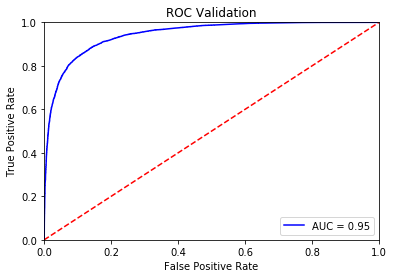

In [133]:
#归一化
print("struct_connective_traindata")
test_size = 0.2
model =XGBClassifier()#SVC()# LogisticRegression()
train_data_file="struct_connective_traindata.csv"
run(model,train_data_file,feature_columns,test_size)

struct_connective_traindata
Accuracy: 87.02%
f1:0.8687891198516343
auc:0.9439003570563745


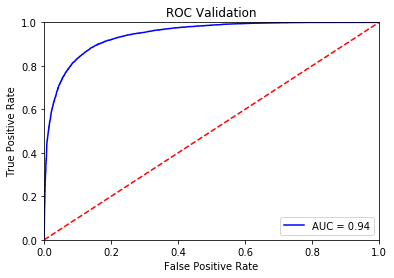

In [131]:
#未归一化
print("struct_connective_traindata")
test_size = 0.2
model =XGBClassifier()#SVC()# LogisticRegression()
train_data_file="struct_connective_traindata.csv"
run(model,train_data_file,feature_columns,test_size)

In [163]:
connectiveSample_embedding="embeddings/all_connectiveSample_node2vec128.txt"
embedding_feature=get_embedding_features(connectiveSample_embedding,pos_edges,neg_edges)

57358 128


In [164]:
train_features = np.hstack((struct_features,embedding_feature))
# 基于边的特征
struct_columns = ["degree1","degree2","centrality1","centrality2","cluster_coefficient1","cluster_coefficient2","resource_allocation","jaccard_coefficient","preferential_attachment"]
embedding_columns=[str(i) for i in range(256)]
all_columns=struct_columns+embedding_columns
train_data = pd.DataFrame(train_features, columns=all_columns)
train_data['label'] = label
feature_file="allfeature_connective_line.csv"
train_data.to_csv(feature_file, index=False)

allfeature_connective_traindata
Accuracy: 87.31%
f1:0.8722105371158878
auc:0.9448031019857664


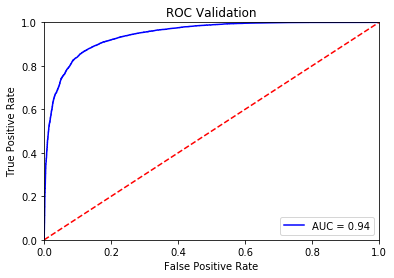

In [165]:
#未归一化
print("allfeature_connective_traindata")
test_size = 0.15
model =XGBClassifier()#SVC()# LogisticRegression()
train_data_file="allfeature_connective_traindata.csv"
run(model,train_data_file,feature_columns,test_size)